In [5]:
import xarray as xr
import numpy as np
import pandas as pd

#### Storm characterisation functions

In [6]:
import gsw
from scipy.interpolate import griddata

def process_storm_data(var, ds_era5, cyclone):

    new_x = np.arange(-1000, 1050, 50)
    new_y = np.arange(-1000, 1050, 50)

    lons = np.ndarray([161])
    lats = np.ndarray([81])
    
    ref_lat = np.round(cyclone.LATITUDE.values, 2)
    ref_lon = np.round(cyclone.LONGITUDE.values, 2)
    
    ds_ = ds_era5.sel(time=cyclone.TIME.values,
                      latitude=slice(np.round(ref_lat) + 10, np.round(ref_lat) - 10),
                      longitude=slice(np.round(ref_lon) - 20.0, np.round(ref_lon) + 20))
     
    lats = ds_.latitude.values
    lons = ds_.longitude.values
    
    # longitude to distance interpolation
    
    dist_from_lon = np.zeros([81, 161])
 
    for j, lt in enumerate(lats):
     
        for i, ln in enumerate(lons):
            dist_from_lon[j, i] = gsw.distance([ln, ref_lon], [lt, lt])[0] / 1000
     
        dist_from_lon[j][lons < ref_lon] = -dist_from_lon[j][lons < ref_lon]
 
    # latitude to distance interpolation
    
    dist_from_lat = np.zeros(lats.size)
 
    for j, lt in enumerate(lats):
        dist_from_lat[j] = gsw.distance([lons[0], lons[0]], [lt, ref_lat])[0] / 1000
 
    dist_from_lat[lats < ref_lat] = -dist_from_lat[lats < ref_lat]
 
    # create xarray dataset 
 
    new_data = np.zeros([81, new_x.size])
 
    final_data = np.zeros([new_x.size, new_y.size])
  
    data = ds_[var]
    for j in range(lats.size):
        new_data[j, :] = griddata(dist_from_lon[j], data[j], new_x)
 
    for i in range(new_x.size):
        final_data[:, i] = griddata(dist_from_lat, new_data[:, i], new_y)
 
    ds_final = xr.Dataset(
        {var: (['time', 'x', 'y'], final_data[np.newaxis, :, :]),
         'pressure': (['time'], [cyclone.PRESSURE_MIN.data]),
         'storm_id': (['time'], [cyclone.STORM_ID.data]),
         },
        coords={
            'x': ('x', new_x),
            'y': ('y', new_y),
            'time': ('time', [pd.to_datetime(cyclone.TIME.data)]),
            'lon': ('time', [ref_lon]),
            'lat': ('time', [ref_lat]),                
        }
    )
    ## Example padding logic (adjust as needed)
    max_time_length = 300  # Define a maximum length for the time dimension
    time_length = ds_final['time'].size  # Get the current length of the time dimension
    #
    if time_length < max_time_length:
        pad_width = max_time_length - time_length
        pad_values = {dim: (0, pad_width) for dim in ds_final.dims if dim == 'time'}
        ds_final = ds_final.pad(pad_values, constant_values=0)           
 
    return ds_final

#### Load data

In [7]:
# load the slocum data

sl_grid = xr.open_dataset('/home/mduplessis/data/slocum/slocum_gridded.nc')
sl_xld  = xr.open_dataset('/home/mduplessis/data/slocum/slocum_xld.nc')
sl_eps  = xr.open_dataset('/home/mduplessis/data/slocum/slocum_epsilon.nc')
sl_sst  = xr.open_dataset('/home/mduplessis/data/slocum/slocum_sst_median_10m.nc')

wg = xr.open_dataset('/home/mduplessis/data/waveglider/WG_era5_1h_processed_28Aug2022.nc')

wg['dayofyear'] = (('date'), wg['dayofyear'].data)
wg = wg.sel(date=slice(wg.date[3], wg.date[-1]))

wg = wg.swap_dims({'date': 'dayofyear'})
# wg = wg.drop_vars('date')

In [8]:
# load the ERA5 datasets

ds_era5_vars = xr.open_dataset('/home/mduplessis/data/era5/ds_era5_vars.nc').load()
ds_era5_flux = xr.open_dataset('/home/mduplessis/data/era5/ds_era5_flux.nc').load()

print('merging')

ds_era5_atl = xr.merge([ds_era5_vars, ds_era5_flux])

# process the ERA5 datasets

ds_era5_atl['sp'] = (('time', 'latitude', 'longitude'), ds_era5_atl['sp'].data/100)

ds_era5_atl['wnd'] = (('time', 'latitude', 'longitude'), np.sqrt(ds_era5_atl['u10']**2 + ds_era5_atl['v10']**2).data)

ds_era5_site = ds_era5_atl.sel(longitude=0, latitude=-54)

import matplotlib.dates as mdates

day0=mdates.date2num(np.datetime64('2019-01-01 00:00:00'))

ds_era5_site['dayofyear']=(('time'), mdates.date2num(ds_era5_site.time)-day0)

ds_era5_site = ds_era5_site.sel(time=slice(sl_xld.time.data[0], sl_xld.time.data[-1]))

ds_era5_site['qnet'] = (('time'), ds_era5_site['sshf'].data + ds_era5_site['slhf'].data + ds_era5_site['str'].data + ds_era5_site['ssr'].data)

ds_era5_site['sthf'] = (('time'), ds_era5_site.sshf.data + ds_era5_site.slhf.data)

import functions.dewpoint_to_rh as dp2rh

ds_era5_site = dp2rh.convert_dp_to_rh(ds_era5_site)

ds_era5_site['dt'] = (('time'), ds_era5_site['t2m'].data - ds_era5_site['sst'].data)

merging


In [9]:
# select the ERA5 data for the slocum grid
ds_era5 = ds_era5_atl.sel(time=ds_era5_site.time.values)

In [10]:
# create a dayofyear variable for the ERA5 dataset
ds_era5['dayofyear']=(('time'), mdates.date2num(ds_era5.time)-day0)

In [11]:
# resize the wave glider dataset and find the correlation to the era5 winds

wg = wg.sel(dayofyear=slice(wg.dayofyear[3], wg.dayofyear[-1]))

# CHANGE THE DATES FOR THE WAVE GLIDER AND ERA5 WINDS

u10_era5 = ds_era5_site.sel(time=slice(wg.date[0], wg.date[-1]))

idx = ~np.isnan(wg['WindSpeed_ms_10m'])

print('corr', np.corrcoef(wg['WindSpeed_ms_10m'].data[idx], u10_era5.wnd.data[idx])[0,1]**2)

print('rmse', np.mean(wg['WindSpeed_ms_10m'].data[idx] - u10_era5.wnd.data[idx]))

corr 0.8037282839515881
rmse 1.2267950197915296


#### Load storms

In [22]:
# No need to run this, but if you want to save the dataset. I have run this already, load in the dataset instead below

In [12]:
storm_centers = xr.open_dataset('/home/mduplessis/data/storms/ec_centers_1981_2020.nc')

In [13]:
# cut to only the storms that we need for the project

storm_centers = storm_centers.isel(
    TIME=((storm_centers.TIME >= np.datetime64('2018-12-19 22:00:00')) & 
          (storm_centers.TIME < np.datetime64('2019-03-09 00:00:00')))
    )

idx = ((storm_centers.LONGITUDE.values > -40) & (storm_centers.LONGITUDE.values < 40))

storm_centers = storm_centers.isel(TIME=idx)

idx = ((storm_centers.LATITUDE.values > -70) & (storm_centers.LATITUDE.values < -30))

storm_centers = storm_centers.isel(TIME=idx)

#### Process the storm centers dataset

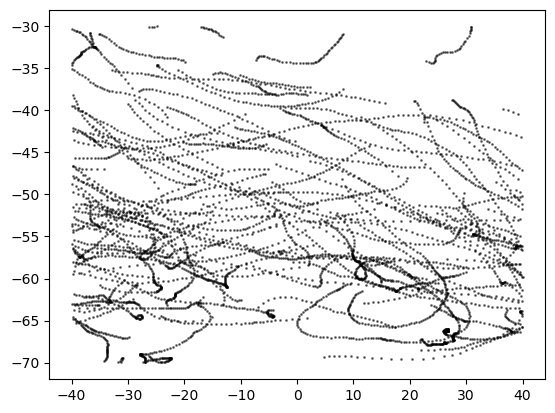

In [14]:
import matplotlib.pyplot as plt

plt.scatter(storm_centers.LONGITUDE.values, storm_centers.LATITUDE.values, s=1, c='k', alpha=0.5)

In [15]:
# process storms -- find if a storm center is within 1000 km of the glider, and if so, process the ERA5 data for that storm

from tqdm import tqdm
import numpy as np
import xarray as xr
import gsw

def process_storms(storm_centers, ds_era5_atl, var='wnd'):

    distance_to_glider = []
    storm_index = []
    ds_final = None
    ds_final_initialized = False

    for i in tqdm(range(storm_centers.STORM_ID.size)):
        ds_storm = storm_centers.isel(TIME=i)
        distance = (gsw.distance([ds_storm.LONGITUDE.values, 0], [ds_storm.LATITUDE.values, -54]) / 1000)[0]

        if distance < 1000:
            distance_to_glider.append(distance)
            storm_index.append(i)

            ds_var = process_storm_data(var, ds_era5_atl, ds_storm)

            if ds_final_initialized:
                ds_final = xr.concat([ds_final, ds_var], dim='time')
            else:
                ds_final = ds_var
                ds_final_initialized = True

    distance_to_glider = np.array(distance_to_glider)
    
    return distance_to_glider, storm_index, ds_final

In [16]:
distance_to_glider, storm_index, ds_storms_shf = process_storms(storm_centers, ds_era5_atl, var='sshf')
distance_to_glider, storm_index, ds_storms_ssr = process_storms(storm_centers, ds_era5_atl, var='ssr')
distance_to_glider, storm_index, ds_storms_lhf = process_storms(storm_centers, ds_era5_atl, var='slhf')
distance_to_glider, storm_index, ds_storms_str = process_storms(storm_centers, ds_era5_atl, var='str')
distance_to_glider, storm_index, ds_storms_wnd = process_storms(storm_centers, ds_era5_atl, var='wnd')


  0%|          | 0/5226 [00:00<?, ?it/s]

100%|██████████| 5226/5226 [12:10<00:00,  7.15it/s] 


In [18]:
ds_storms_ssr = ds_storms_ssr.sel(time=ds_storms_ssr.time<np.datetime64('2019-03-10 00:00:00'))
ds_storms_lhf = ds_storms_lhf.sel(time=ds_storms_lhf.time<np.datetime64('2019-03-10 00:00:00'))
ds_storms_shf = ds_storms_shf.sel(time=ds_storms_shf.time<np.datetime64('2019-03-10 00:00:00'))
ds_storms_str = ds_storms_str.sel(time=ds_storms_str.time<np.datetime64('2019-03-10 00:00:00'))
ds_storms_wnd = ds_storms_wnd.sel(time=ds_storms_wnd.time<np.datetime64('2019-03-10 00:00:00'))


In [20]:
xr.merge([ds_storms_ssr, ds_storms_str, ds_storms_shf, ds_storms_lhf, ds_storms_wnd]).to_netcdf('/home/mduplessis/data/storms/storms_soscex.nc')

In [ ]:
# now load the storm data

In [21]:
storms_soscex = xr.merge([ds_storms_ssr, ds_storms_str, ds_storms_shf, ds_storms_lhf, ds_storms_wnd])

In [ ]:
storms_soscex

<xarray.Dataset> Size: 58MB
Dimensions:   (time: 867, x: 41, y: 41)
Coordinates:
  * x         (x) int64 328B -1000 -950 -900 -850 -800 ... 800 850 900 950 1000
  * y         (y) int64 328B -1000 -950 -900 -850 -800 ... 800 850 900 950 1000
  * time      (time) datetime64[ns] 7kB 2018-12-19T22:00:00 ... 2019-03-08T01...
    lon       (time) float64 7kB -4.46 -3.79 -3.15 -2.51 ... 11.87 13.02 14.13
    lat       (time) float64 7kB -48.52 -48.81 -49.09 ... -57.52 -57.47 -57.46
Data variables:
    ssr       (time, x, y) float64 12MB 14.71 18.34 ... 3.472e-05 3.472e-05
    pressure  (time) float64 7kB 973.5 971.5 970.2 968.7 ... 986.3 985.6 985.3
    storm_id  (time) int64 7kB 73537 73537 73537 73537 ... 73886 73886 73886
    str       (time, x, y) float64 12MB -17.47 -34.9 -42.22 ... -102.5 -101.7
    sshf      (time, x, y) float64 12MB -0.7372 -3.022 -10.58 ... -23.8 -17.6
    slhf      (time, x, y) float64 12MB -4.672 -13.55 -22.5 ... -94.2 -77.58
    wnd       (time, x, y) float64 12MB 3.649 5.649 8.003 ... 11.34 11.1 10.58